The goal of this project is to build a talent matching system that accurately matches candidates’ resumes with job descriptions to assess whether a candidate is a good fit for a given role. This problem will be approached using two distinct methodologies: one employing traditional machine learning and natural language processing (NLP) techniques and another utilizing GPT models.

The traditional approach will involve feature extraction using NLP techniques such as TF-IDF, word embeddings (Word2Vec or GloVe), and classification algorithms such as logistic regression, support vector machines (SVM), or random forests. On the other hand, the system using GPT will leverage advanced language models to comprehend and interpret the semantic meaning of resumes and job descriptions, providing an intelligent match based on context and skills alignment.

Throughout the project, we will implement both solutions, evaluate their performance using key metrics such as accuracy, precision, recall, and F1-score, and measure computational efficiency. The outcomes of these two approaches will be compared to determine which method yields better performance in terms of predictive power, scalability, and adaptability to various industries.

By the end of this project, we aim to provide insights into the effectiveness of state-of-the-art language models like GPT compared to more conventional machine learning techniques in the domain of talent matching. These results will help guide future applications in AI-powered recruitment systems.

First, we will input the dataset of 12000 resumes to our notebook.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv

In [2]:
df = pd.read_csv('data/resume/Resume/Resume.csv')

In [3]:
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
import pandas as pd
from PyPDF2 import PdfReader
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1028)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1028)>
[nltk_data] Error loading averaged_perceptron_tagger_eng: <urlopen
[nltk_data]     error [SSL: CERTIFICATE_VERIFY_FAILED] certificate
[nltk_data]     verify failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:1028)>
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
resume_data = pd.read_csv('data/resume/Resume/Resume.csv')
resume_data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


EDA and Visualizing the Resume Dataset Distribution

In [6]:
resume_data.describe().T
resume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


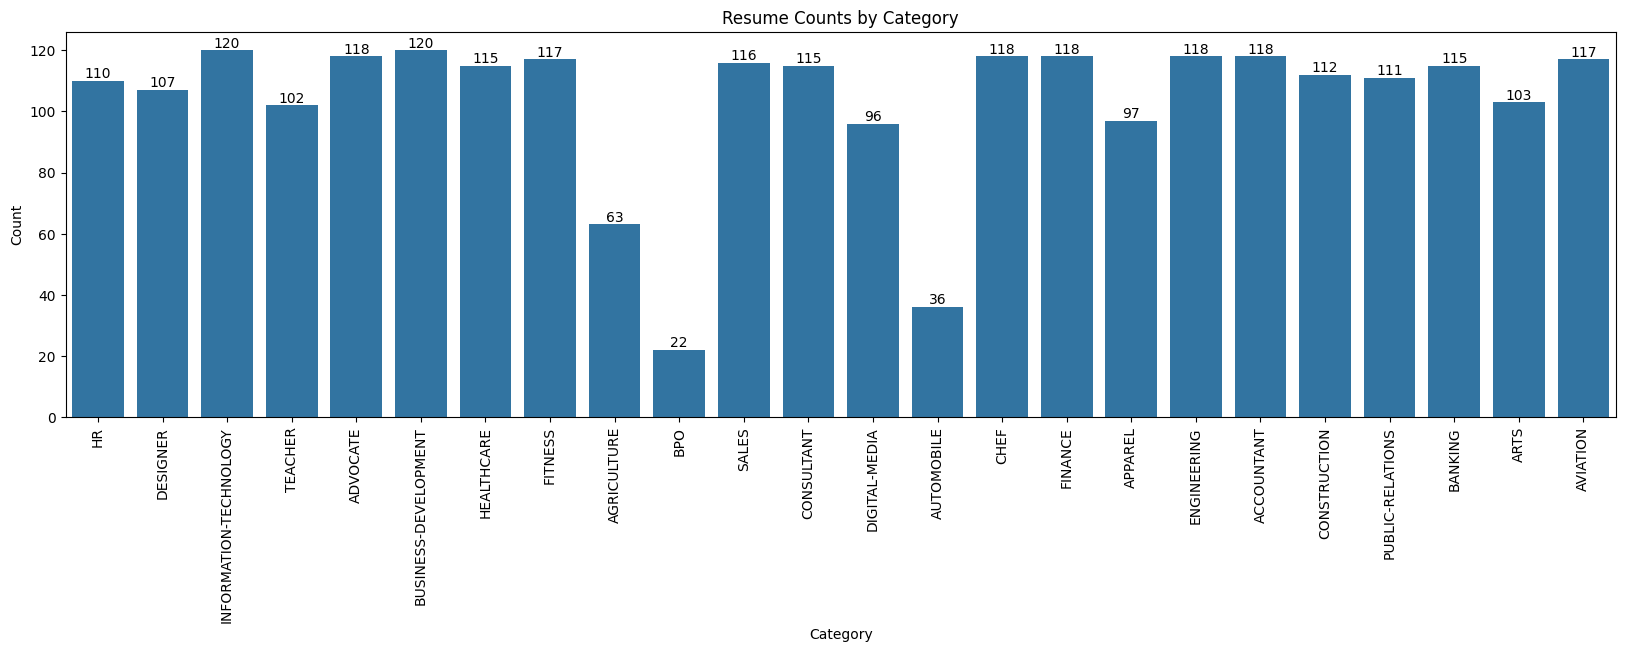

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size and rotation for x-ticks
plt.figure(figsize=(20, 5))
plt.xticks(rotation=90)

# Create a count plot
ax = sns.countplot(x="Category", data=resume_data)

# Annotate each bar with its height (the count value)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Add gridlines for clarity
plt.title("Resume Counts by Category")
plt.ylabel("Count")
plt.xlabel("Category")

# Show the plot
plt.show()


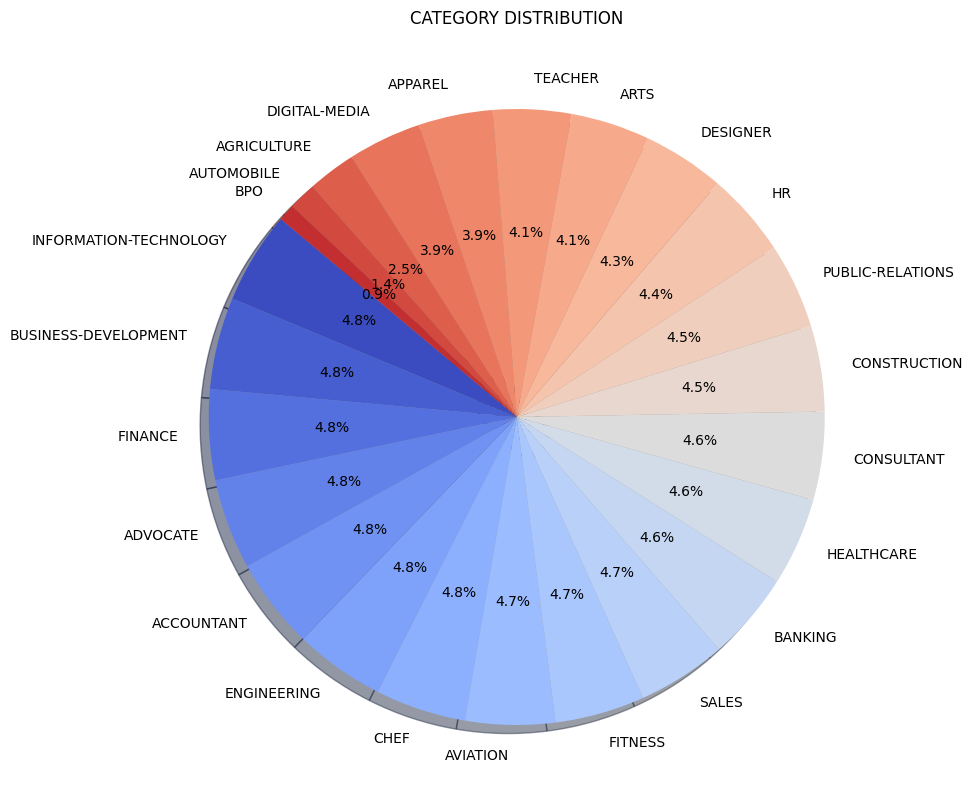

In [8]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

# Get category counts and labels
targetCounts = resume_data['Category'].value_counts()
targetLabels = targetCounts.index  # Ensures labels align with counts

# Create a figure
plt.figure(1, figsize=(22, 22))
the_grid = GridSpec(2, 2)

# Generate a colormap
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i / len(targetCounts)) for i in range(len(targetCounts))]

# Plot the pie chart
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')
plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors, startangle=140)

# Show the plot
plt.show()

In [9]:
resume_data = resume_data.drop(["Resume_html"], axis=1)
resume_data.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [10]:
resume_data.Resume_str[0]

"         HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commitment to customer service.         Highlights         Focused on customer satisfaction  Team management  Marketing savvy  Conflict resolution techniques     Training and development  Skilled multi-tasker  Client relations specialist           Accomplishments      Missouri DOT Supervisor Training Certification  Certified by IHG in Customer Loyalty and Marketing by Segment   Hilton Worldwide General Manager Training Certification  Accomplished Trainer for cross server hospitality systems such as    Hilton OnQ  ,   Micros    Opera PMS   , Fidelio    OPERA    Reservation System (ORS) ,   Holidex    Completed courses and seminars in customer service, sales strategies, inventory control, loss pr

In [12]:
df.shape

(2484, 4)

In [13]:
resume_data.shape

(2484, 3)

In [15]:
resume_data['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

Cleaning data

In [16]:
import re

def cleanResume(txt):
    # Remove URLs
    txt = re.sub(r'http\S+|www\S+|https\S+', ' ', txt, flags=re.IGNORECASE)

    # Remove RT and cc (Twitter slang, optional)
    txt = re.sub(r'\bRT\b|\bcc\b', ' ', txt)

    # Remove hashtags but keep the word (e.g., "#python" -> "python")
    txt = re.sub(r'#(\w+)', r'\1', txt)

    # Remove mentions (@username)
    txt = re.sub(r'@\w+', ' ', txt)

    # Remove non-ASCII characters (accents, emojis, etc.)
    txt = re.sub(r'[^\x00-\x7f]', ' ', txt)

    # Remove punctuation and special characters
    txt = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', txt)

    # Normalize whitespace
    txt = re.sub(r'\s+', ' ', txt).strip()

    # Convert to lowercase
    txt = txt.lower()

    return txt


In [17]:
resume_data['Resume_str'] = resume_data['Resume_str'].apply(lambda x: cleanResume(x))

In [18]:
resume_data.Resume_str[0]

'hr administrator marketing associate hr administrator summary dedicated customer service manager with 15 years of experience in hospitality and customer service management respected builder and leader of customer focused teams strives to instill a shared enthusiastic commitment to customer service highlights focused on customer satisfaction team management marketing savvy conflict resolution techniques training and development skilled multi tasker client relations specialist accomplishments missouri dot supervisor training certification certified by ihg in customer loyalty and marketing by segment hilton worldwide general manager training certification accomplished trainer for cross server hospitality systems such as hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses and seminars in customer service sales strategies inventory control loss prevention safety time management leadership and performance assessment experience hr administrator marketin


Words into Categorical Value

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [20]:
le.fit(resume_data['Category'])
resume_data['Category'] =le.transform(resume_data['Category'])

In [21]:
resume_data.head()

,ID,Resume_str,Category
0,16852973,hr administrator marketing associate hr admini...,19
1,22323967,hr specialist us hr operations summary versati...,19
2,33176873,hr director summary over 20 years experience i...,19
3,27018550,hr specialist summary dedicated driven and dyn...,19
4,17812897,hr manager skill highlights hr skills hr depar...,19


In [27]:
resume_data.Category.value_counts()

Category
20    120
9     120
16    118
1     118
0     118
15    118
10    118
6     117
17    117
22    116
7     115
18    115
12    115
11    112
21    111
19    110
13    107
4     103
23    102
3      97
14     96
2      63
5      36
8      22
Name: count, dtype: int64

In [ ]:
'''
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
'''

Vectorization

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf.fit(resume_data['Resume_str'])
vec_text = tfidf.transform(resume_data['Resume_str'])

In [30]:
print(vec_text[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 304 stored elements and shape (1, 39961)>
  Coords	Values
  (0, 370)	0.028023458372714787
  (0, 594)	0.030656515179776356
  (0, 595)	0.058110088857052385
  (0, 638)	0.053907403279221486
  (0, 646)	0.04836782601760144
  (0, 652)	0.041831017798287184
  (0, 668)	0.05686029081837976
  (0, 671)	0.017575446629468375
  (0, 675)	0.034217641546389184
  (0, 2253)	0.0441727592005735
  (0, 2360)	0.03515282770941851
  (0, 2366)	0.01916557107356091
  (0, 2386)	0.04898960163175399
  (0, 2419)	0.02602981713632939
  (0, 2550)	0.018580805536603667
  (0, 2714)	0.05891428970258174
  (0, 2720)	0.03988150454201519
  (0, 2726)	0.12933542929039474
  (0, 2778)	0.04556153161407346
  (0, 2792)	0.027414861482230473
  (0, 2823)	0.12197520541298841
  (0, 2837)	0.062343007696688275
  (0, 3520)	0.029748160833411055
  (0, 3625)	0.037316178499142066
  (0, 3627)	0.029599681964556396
  :	:
  (0, 35204)	0.05891428970258174
  (0, 35335)	0.01769784205462053
  (0,

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vec_text, resume_data['Category'], test_size = 0.2 , random_state=42)

In [32]:
X_train.shape

(1987, 39961)

In [33]:
X_test.shape

(497, 39961)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000))
clf.fit(X_train, y_train)
ypredict = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, ypredict))
print("F1 Score:", f1_score(y_test, ypredict, average='weighted'))



Accuracy: 0.6317907444668008
F1 Score: 0.6204656839574552


Step 1: Import Libraries

In [39]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [43]:
import nltk
print(nltk.data.path)



['/Users/rkuma07/nltk_data', '/Users/rkuma07/Desktop/Resume_Filtering/venv/nltk_data', '/Users/rkuma07/Desktop/Resume_Filtering/venv/share/nltk_data', '/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [46]:
import re

def cleanResume(txt):
    # Remove URLs
    txt = re.sub(r'http\S+|www\S+|https\S+', ' ', txt)
    
    # Remove RT and cc
    txt = re.sub(r'\bRT\b|\bcc\b', ' ', txt)
    
    # Remove hashtags (#word -> word)
    txt = re.sub(r'#(\w+)', r'\1', txt)
    
    # Remove mentions
    txt = re.sub(r'@\w+', ' ', txt)
    
    # Remove non-ASCII characters
    txt = re.sub(r'[^\x00-\x7f]', ' ', txt)
    
    # Remove punctuation
    txt = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', txt)
    
    # Remove digits
    txt = re.sub(r'\d+', ' ', txt)
    
    # Normalize whitespace
    txt = re.sub(r'\s+', ' ', txt).strip()
    
    # Lowercase
    txt = txt.lower()
    
    return txt


In [47]:
# Assuming you already have your DataFrame as 'resume_data' with columns ['Resume_str', 'Category']

resume_data['Resume_str'] = resume_data['Resume_str'].apply(cleanResume)


In [48]:
le = LabelEncoder()
resume_data['Category'] = le.fit_transform(resume_data['Category'])


In [49]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.85, min_df=5, ngram_range=(1,2))
vec_text = tfidf.fit_transform(resume_data['Resume_str'])


In [50]:
X_train, X_test, y_train, y_test = train_test_split(vec_text, resume_data['Category'], test_size=0.2, random_state=42)


In [51]:
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000, C=1))
clf.fit(X_train, y_train)


,estimator,LogisticRegre...r='liblinear')
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


In [53]:
from sklearn.metrics import classification_report

print("Accuracy:", accuracy_score(y_test, ypredict))
print("F1 Score:", f1_score(y_test, ypredict, average='weighted'))

# Fix here:
target_names = [str(cls) for cls in le.classes_]
print("\nClassification Report:\n", classification_report(y_test, ypredict, target_names=target_names))



Accuracy: 0.6498993963782697
F1 Score: 0.638451085878137

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.52      0.53      0.52        30
           2       1.00      0.12      0.22         8
           3       0.54      0.35      0.42        20
           4       0.25      0.17      0.20        18
           5       0.00      0.00      0.00         6
           6       0.72      0.86      0.78        21
           7       0.71      0.65      0.68        23
           8       0.00      0.00      0.00         2
           9       0.95      0.74      0.83        27
          10       0.86      0.75      0.80        24
          11       0.89      0.74      0.81        34
          12       0.56      0.25      0.34        20
          13       0.80      0.84      0.82        19
          14       0.94      0.64      0.76        25
          15       0.54      0.71      0.61        21

/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [54]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [55]:
def cleanResume(txt):
    txt = re.sub(r'http\S+|www\S+|https\S+', ' ', txt)
    txt = re.sub(r'\bRT\b|\bcc\b', ' ', txt)
    txt = re.sub(r'#(\w+)', r'\1', txt)
    txt = re.sub(r'@\w+', ' ', txt)
    txt = re.sub(r'[^\x00-\x7f]', ' ', txt)
    txt = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', txt)
    txt = re.sub(r'\d+', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    return txt.lower()


In [56]:
resume_data['Resume_str'] = resume_data['Resume_str'].apply(cleanResume)


In [57]:
# Drop classes with <10 examples
class_counts = resume_data['Category'].value_counts()
valid_classes = class_counts[class_counts >= 10].index
resume_data = resume_data[resume_data['Category'].isin(valid_classes)].copy()


In [58]:
le = LabelEncoder()
resume_data['Category'] = le.fit_transform(resume_data['Category'])


In [59]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.85, min_df=3, ngram_range=(1, 2))
vec_text = tfidf.fit_transform(resume_data['Resume_str'])


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    vec_text, resume_data['Category'], test_size=0.2, random_state=42, stratify=resume_data['Category']
)


In [61]:
clf = OneVsRestClassifier(LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced'  # handles imbalance
))

clf.fit(X_train, y_train)


,estimator,LogisticRegre...r='liblinear')
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None


In [62]:
ypredict = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, ypredict))
print("F1 Score:", f1_score(y_test, ypredict, average='weighted'))

# Fix target names
target_names = [str(cls) for cls in le.classes_]

print("\nClassification Report:\n", classification_report(y_test, ypredict, target_names=target_names))


Accuracy: 0.6720321931589537
F1 Score: 0.6611336402540147

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.83      0.75        24
           1       0.42      0.58      0.49        24
           2       0.78      0.54      0.64        13
           3       0.50      0.21      0.30        19
           4       0.54      0.33      0.41        21
           5       1.00      0.29      0.44         7
           6       0.81      0.71      0.76        24
           7       0.76      0.70      0.73        23
           8       0.00      0.00      0.00         4
           9       0.56      0.92      0.70        24
          10       0.81      0.71      0.76        24
          11       0.81      0.77      0.79        22
          12       0.58      0.30      0.40        23
          13       0.85      0.81      0.83        21
          14       0.69      0.47      0.56        19
          15       0.72      0.75      0.73        2

/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

In [63]:
!pip install sentence-transformers



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [64]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sentence_transformers import SentenceTransformer


In [65]:
def cleanResume(txt):
    txt = re.sub(r'http\S+|www\S+|https\S+', ' ', txt)
    txt = re.sub(r'\bRT\b|\bcc\b', ' ', txt)
    txt = re.sub(r'#(\w+)', r'\1', txt)
    txt = re.sub(r'@\w+', ' ', txt)
    txt = re.sub(r'[^\x00-\x7f]', ' ', txt)
    txt = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', txt)
    txt = re.sub(r'\d+', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    return txt.lower()


In [66]:
resume_data['Resume_str'] = resume_data['Resume_str'].apply(cleanResume)

class_counts = resume_data['Category'].value_counts()
valid_classes = class_counts[class_counts >= 10].index
resume_data = resume_data[resume_data['Category'].isin(valid_classes)].copy()


In [67]:
le = LabelEncoder()
resume_data['Category'] = le.fit_transform(resume_data['Category'])


In [68]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast + accurate
X = model.encode(resume_data['Resume_str'], show_progress_bar=True)


Batches: 100%|██████████| 78/78 [00:11<00:00,  6.58it/s]


In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, resume_data['Category'], test_size=0.2, random_state=42, stratify=resume_data['Category']
)


In [70]:
clf = OneVsRestClassifier(LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced'
))
clf.fit(X_train, y_train)


,estimator,LogisticRegre...r='liblinear')
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None


In [71]:
ypredict = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, ypredict))
print("F1 Score:", f1_score(y_test, ypredict, average='weighted'))

target_names = [str(cls) for cls in le.classes_]
print("\nClassification Report:\n", classification_report(y_test, ypredict, target_names=target_names))


Accuracy: 0.7082494969818913
F1 Score: 0.7044421743110619

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82        24
           1       0.67      0.58      0.62        24
           2       0.53      0.69      0.60        13
           3       0.75      0.32      0.44        19
           4       0.29      0.19      0.23        21
           5       0.30      0.43      0.35         7
           6       0.76      0.79      0.78        24
           7       0.54      0.57      0.55        23
           8       0.40      0.50      0.44         4
           9       0.73      0.79      0.76        24
          10       0.91      0.83      0.87        24
          11       0.85      0.77      0.81        22
          12       0.67      0.52      0.59        23
          13       0.91      0.95      0.93        21
          14       0.82      0.74      0.78        19
          15       0.90      0.79      0.84        2

In [72]:
!pip install sentence-transformers
!pip install xgboost


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [73]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier


In [74]:
def cleanResume(txt):
    txt = re.sub(r'http\S+|www\S+|https\S+', ' ', txt)
    txt = re.sub(r'\bRT\b|\bcc\b', ' ', txt)
    txt = re.sub(r'#(\w+)', r'\1', txt)
    txt = re.sub(r'@\w+', ' ', txt)
    txt = re.sub(r'[^\x00-\x7f]', ' ', txt)
    txt = re.sub(r'[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"""), ' ', txt)
    txt = re.sub(r'\d+', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    return txt.lower()


In [75]:
resume_data['Resume_str'] = resume_data['Resume_str'].apply(cleanResume)

# Drop classes with <10 samples
valid_classes = resume_data['Category'].value_counts()
valid_classes = valid_classes[valid_classes >= 10].index
resume_data = resume_data[resume_data['Category'].isin(valid_classes)].copy()


In [76]:
le = LabelEncoder()
resume_data['Category'] = le.fit_transform(resume_data['Category'])


In [77]:
# This is a more powerful BERT-based encoder than MiniLM
model = SentenceTransformer('all-mpnet-base-v2')
X = model.encode(resume_data['Resume_str'], show_progress_bar=True)


{"timestamp":"2025-06-06T15:18:52.943306Z","level":"WARN","fields":{"message":"Reqwest(reqwest::Error { kind: Request, url: \"https://transfer.xethub.hf.co/xorbs/default/ae56b8079f9a152192ac3e5cb34c3b3ba5a56b75b996a2d77a6757712bf12d7c?X-Xet-Signed-Range=bytes%3D0-62293607&Expires=1749226732&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly90cmFuc2Zlci54ZXRodWIuaGYuY28veG9yYnMvZGVmYXVsdC9hZTU2YjgwNzlmOWExNTIxOTJhYzNlNWNiMzRjM2IzYmE1YTU2Yjc1Yjk5NmEyZDc3YTY3NTc3MTJiZjEyZDdjP1gtWGV0LVNpZ25lZC1SYW5nZT1ieXRlcyUzRDAtNjIyOTM2MDciLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NDkyMjY3MzJ9fX1dfQ__&Signature=YK8ImKBJ3JvvcXaYfbCKNMWiSsYX4HzQEED763ao-eBnTCrroYovsTX-Z4Cjzc4p-X1AlbeWn6RXVbUhcl10lvBxmGXfpiFEBCQ7JNJm7fNmzVfCDuaVN-WGO7T1~1fFWSQMcwYglXbk3CbOCHNfi09KMGYIsnatQ14-~3pUB0XmjuBZJeg~gOcCpGEHzLFjbzmM8JetnmfsCfwNg35yaSQCON7xLJ1OPAKuyDpWVn~Y0il4ZZvr7aLKvudR7-vPvXlNTDPX15-cpOz~wsg5MyDz2Jo4xukBsYgGKQhjAnmAufyKdo1jVluwb~VpVVUjG4jKU2a5RaHq0WPEBMbEGQ__&Key-Pair-Id=K2L8F4GPSG1IFC\",

Batches: 100%|██████████| 78/78 [01:18<00:00,  1.01s/it]


In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X, resume_data['Category'], test_size=0.2, random_state=42, stratify=resume_data['Category']
)


In [79]:
clf = OneVsRestClassifier(XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5
))

clf.fit(X_train, y_train)


/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:51:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:51:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:51:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:51:56] WARNING: /Users/runner/work/

,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,verbose,0
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None


In [80]:
ypredict = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, ypredict))
print("F1 Score:", f1_score(y_test, ypredict, average='weighted'))

target_names = [str(cls) for cls in le.classes_]
print("\nClassification Report:\n", classification_report(y_test, ypredict, target_names=target_names))


Accuracy: 0.7183098591549296
F1 Score: 0.7093873926494791

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        24
           1       0.59      0.54      0.57        24
           2       0.90      0.69      0.78        13
           3       0.42      0.26      0.32        19
           4       0.50      0.38      0.43        21
           5       0.25      0.14      0.18         7
           6       0.82      0.75      0.78        24
           7       0.61      0.74      0.67        23
           8       0.00      0.00      0.00         4
           9       0.81      0.88      0.84        24
          10       0.95      0.79      0.86        24
          11       0.84      0.73      0.78        22
          12       0.65      0.65      0.65        23
          13       0.78      1.00      0.88        21
          14       0.80      0.63      0.71        19
          15       0.91      0.83      0.87        2

/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rkuma07/Desktop/Resume_Filtering/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

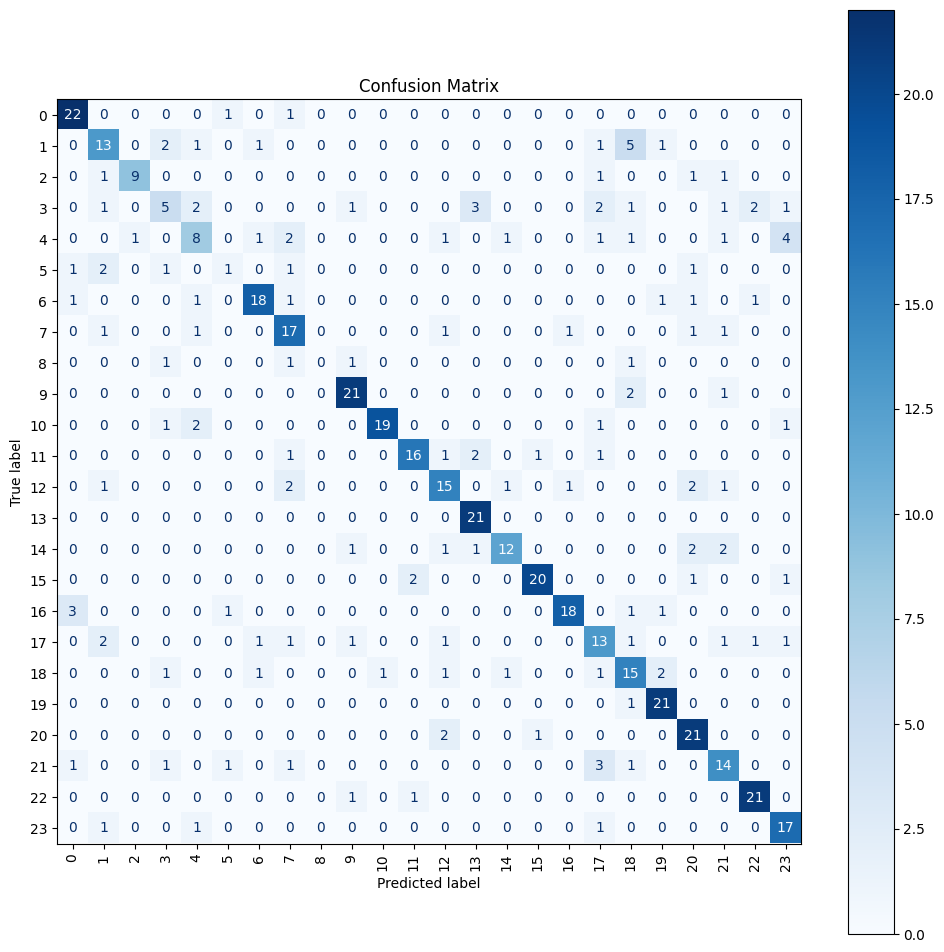

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, ypredict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()


In [82]:
!pip install transformers datasets scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 2.0 MB/s eta 0:00:0000:0100:01
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset
import torch
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
